## Travel Sales Man(TSP) Problem :-

### ============================================================
###  COMPARISON BETWEEN SIMULATED ANNEALING (SA)
###  AND GENETIC ALGORITHM (GA)
### ============================================================

In [91]:

# ---------------------------
# IMPORT LIBRARIES
# ---------------------------
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
random.seed(42)
np.random.seed(42)

# ---------------------------
# Load cities coordinates
# ---------------------------

def load_cities(filename):
    points = []       # list of (x, y) coordinates
    names = []        # optional: list of city names

    with open(filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)

        for row in reader:
            city_name = row["City"]
            x = float(row["X"])
            y = float(row["Y"])

            names.append(city_name)
            points.append((x, y))

    return points, names


### ============================================================
### PART 1: SIMULATED ANNEALING (SA)
### ============================================================

In [92]:
#initlise the minimum x and y
#initlise the maximum x and y
min_vals = [float('inf'), float('inf')]
max_vals = [float('-inf'), float('-inf')]

#define the range of x and y
for row in cities:
    for col_idx in range(len(row)):
        if row[col_idx] < min_vals[col_idx]:
            min_vals[col_idx] = row[col_idx]
        if row[col_idx] > max_vals[col_idx]:
            max_vals[col_idx] = row[col_idx]

print(min_vals[0],max_vals[0],min_vals[1], max_vals[1])

0.552211712 96.95846278 4.645041272 98.68869366


In [93]:
# COMMON Functions
def euclidean_distance(city1, city2):
    ##Compute Euclidean distance between two cities sqrt[(y2-y1)²-(x2-x1)²]
    return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def total_distance(route):
    """
     Circular tour distance;
     from city1 and turn back to city1 as the finishing city
    """
    distance = 0
    for i in range(len(route)):
        city_a = route[i]
        city_b = route[(i + 1) % len(route)]  # Wrap around to first city
        dx = city_a[0] - city_b[0]
        dy = city_a[1] - city_b[1]
        distance += math.sqrt(dx**2 + dy**2)
    return distance

In [94]:
# Create a neighbor route by swapping two cities
def get_neighbor(route):
    neighbor = route[:]           # copy
    i, j = random.sample(range(len(route)), 2)
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

In [95]:
# ---- SIMULATED ANNEALING ----
def simulated_annealing_tsp(cities, n_iterations=1000, temp=1000):

    # 1. Initial random route
    route = random.sample(cities, len(cities))
    current_eval = total_distance(route)


    best_route_sa = route[:] #copy
    best_eval = current_eval

    scores = [best_eval]

    # ---- MAIN LOOP ----
    for i in range(1, n_iterations + 1):
        # Cooling schedule
        t = temp / (i + 1)

        # 2. Propose a neighbor
        candidate = get_neighbor(route)
        # Evaluate candidate route
        candidate_eval= total_distance(candidate)

        # compare between current and candidate
        if (candidate_eval < current_eval) or \
           (random.random() < math.exp((current_eval - candidate_eval) / t)):
            route = candidate
            current_eval = candidate_eval

            # updating global best ruote
            if candidate_eval < best_eval:
                best_route_sa = candidate[:]
                best_eval = candidate_eval
                scores.append(best_eval)

        # Debug printing every 100 loop
        if i % 100 == 0:
            print(f"Iteration {i}, Temp {t:.3f}, Best Distance {best_eval:.4f}")

    return best_route_sa, best_eval, scores

# -------- TEST THE CODE --------
cities, names = load_cities("cities.csv")

best_route_sa, best_distance, scores = simulated_annealing_tsp(cities, n_iterations=1000, temp=1000)
best_route_sa.append(best_route_sa[0])
# mapping between names and coordinates
city_lookup = {city: name for city, name in zip(cities, names)}
named_route = [city_lookup[city] for city in best_route_sa]

print("Best Route (by city names):")
print(" → ".join(named_route))

print("Best Route:", best_route_sa)
print("Best Distance:", best_distance)


Iteration 100, Temp 9.901, Best Distance 1856.0930
Iteration 200, Temp 4.975, Best Distance 1584.0732
Iteration 300, Temp 3.322, Best Distance 1451.2871
Iteration 400, Temp 2.494, Best Distance 1372.7414
Iteration 500, Temp 1.996, Best Distance 1354.0548
Iteration 600, Temp 1.664, Best Distance 1311.9317
Iteration 700, Temp 1.427, Best Distance 1294.1665
Iteration 800, Temp 1.248, Best Distance 1258.0806
Iteration 900, Temp 1.110, Best Distance 1182.0469
Iteration 1000, Temp 0.999, Best Distance 1034.2609
Best Route (by city names):
City_12 → City_31 → City_19 → City_40 → City_5 → City_41 → City_45 → City_32 → City_48 → City_47 → City_2 → City_29 → City_50 → City_3 → City_8 → City_30 → City_14 → City_24 → City_9 → City_44 → City_18 → City_26 → City_27 → City_38 → City_28 → City_1 → City_22 → City_37 → City_46 → City_33 → City_21 → City_10 → City_25 → City_11 → City_16 → City_49 → City_13 → City_35 → City_4 → City_6 → City_17 → City_34 → City_23 → City_42 → City_15 → City_39 → City_36 →

### ============================================================
### PART 2: GENETIC ALGORITHM (GA)
### ============================================================

In [96]:

def order_crossover(survivors):
    ##Perform Order Crossover (OX) between two parents.
    midway = len(survivors) // 2
    for i in range(midway):
      parent1, parent2 = survivors[i], survivors[i + midway]

    size = len(parent1)

    # --- 1. Choose two random crossover points ---
    start = random.randint(0, size - 2)
    end = random.randint(start + 1, size - 1)

    # --- 2. Create empty child ---
    child = [None] * size

    # --- 3. Copy the slice from Parent 1 into the child ---
    child[start:end + 1] = parent1[start:end + 1]

    # --- 4. Fill remaining positions with items from Parent 2 (in order) ---
    p2_index = 0
    for i in range(size):
        if child[i] is None:
            # Find next valid city from parent2 that is not in the slice
            while parent2[p2_index] in child:
                p2_index += 1
            child[i] = parent2[p2_index]
            p2_index += 1

    return child


In [97]:
def generate_random_paths(total_destinations):
    random_paths = []
    for _ in range(2000):
        random_path = list(range(1, total_destinations))
        random.shuffle(random_path)
        random_path = [0] + random_path
        random_paths.append(random_path)
    return random_paths


def total_distance_ga(points, path):
    return sum(math.dist(points[path[i - 1]], points[path[i]]) for i in range(len(path)))


def choose_survivors(points, old_generation):
    survivors = []
    random.shuffle(old_generation)
    midway = len(old_generation) // 2
    for i in range(midway):
        if total_distance_ga(points, old_generation[i]) < total_distance_ga(points, old_generation[i + midway]):
            survivors.append(old_generation[i])
        else:
            survivors.append(old_generation[i + midway])
    return survivors

# using order crossover OX
def create_offspring(parent_a, parent_b):
    offspring = []
    start = random.randint(0, len(parent_a) - 1)
    finish = random.randint(start, len(parent_a))
    size = len(parent_a)

    # --- 2. Create empty child ---
    child = [None] * size
    child[start:finish + 1] = parent_a[start:finish + 1]

    # --- 4. Fill remaining positions with items from Parent 2 (in order) ---
    p2_index = 0
    for i in range(size):
        if child[i] is None:
            # Find next valid city from parent2 that is not in the slice
            while parent_b[p2_index] in child:
                p2_index += 1
            child[i] = parent_b[p2_index]
            p2_index += 1
    return child


def apply_crossovers(survivors):
    offsprings = []
    midway = len(survivors) // 2
    for i in range(midway):
        parent_a, parent_b = survivors[i], survivors[i + midway]
        for _ in range(2):
            offsprings.append(create_offspring(parent_a, parent_b))
            offsprings.append(create_offspring(parent_b, parent_a))
    return offsprings


def apply_mutations(generation):
    gen_wt_mutations = []
    for path in generation:
        if random.randint(0, 1000) < 9:
            index1, index2 = random.randint(1, len(path) - 1), random.randint(1, len(path) - 1)
            path[index1], path[index2] = path[index2], path[index1]
        gen_wt_mutations.append(path)
    return gen_wt_mutations


def generate_new_population(points, old_generation):
    survivors = choose_survivors(points, old_generation)
    crossovers = apply_crossovers(survivors)
    #crossovers = order_crossover_test(survivors)
    new_population = apply_mutations(crossovers)
    return new_population


def choose_best(points, paths, count):
    return sorted(paths, key=lambda path: total_distance_ga(points, path))[:count]


def choose_worst(points, paths, count):
    return sorted(paths, reverse=True, key=lambda path: total_distance(points, path))[:count]


def choose_random(paths, count):
    return [random.choice(paths) for _ in range(count)]




In [98]:
points, names = load_cities("cities.csv")
total_destinations = len(points)

# initial population
population = generate_random_paths(total_destinations)

# evolve
for generation in range(200):
    population = generate_new_population(points, population)

# best path
best_route = choose_best(points, population, 1)[0]
best_route_ga = best_route + [best_route[0]]
print("Best path (indices):", best_route_ga)
print("Best path (city names):", [names[i] for i in best_route_ga])
print("Distance:", total_distance_ga(points, best_route))


Best path (indices): [0, 34, 5, 16, 36, 3, 21, 26, 17, 25, 40, 43, 46, 37, 4, 47, 1, 44, 27, 12, 31, 35, 6, 19, 38, 15, 14, 10, 24, 48, 30, 39, 41, 18, 7, 28, 2, 9, 29, 49, 11, 20, 42, 8, 32, 22, 13, 23, 45, 33, 0]
Best path (city names): ['City_1', 'City_35', 'City_6', 'City_17', 'City_37', 'City_4', 'City_22', 'City_27', 'City_18', 'City_26', 'City_41', 'City_44', 'City_47', 'City_38', 'City_5', 'City_48', 'City_2', 'City_45', 'City_28', 'City_13', 'City_32', 'City_36', 'City_7', 'City_20', 'City_39', 'City_16', 'City_15', 'City_11', 'City_25', 'City_49', 'City_31', 'City_40', 'City_42', 'City_19', 'City_8', 'City_29', 'City_3', 'City_10', 'City_30', 'City_50', 'City_12', 'City_21', 'City_43', 'City_9', 'City_33', 'City_23', 'City_14', 'City_24', 'City_46', 'City_34', 'City_1']
Distance: 969.2527599596303


### ============================================================
### PART 3:comparision
### ============================================================

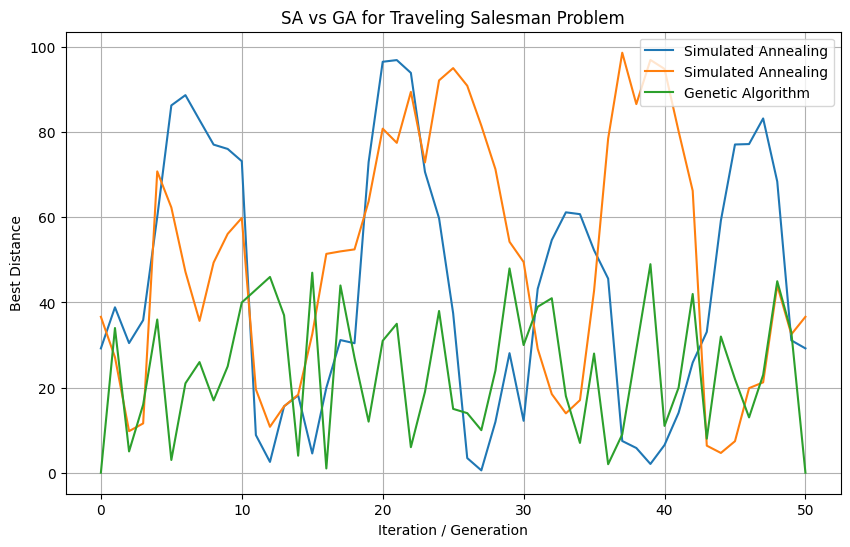

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(best_route_sa, label="Simulated Annealing")
plt.plot(best_route_ga, label="Genetic Algorithm")
plt.xlabel("Iteration / Generation")
plt.ylabel("Best Distance")
plt.title("SA vs GA for Traveling Salesman Problem")
plt.legend()
plt.grid(True)
plt.show()

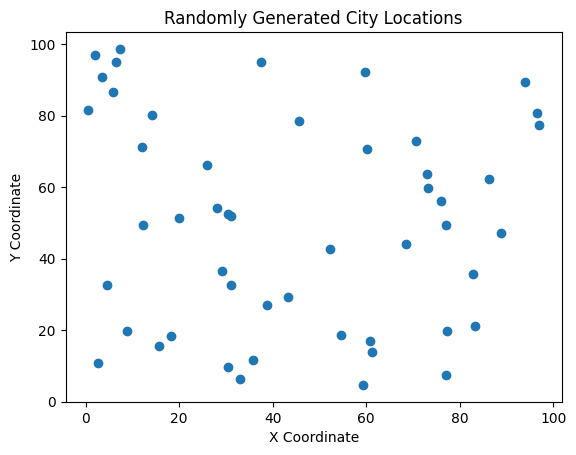

In [100]:
# 2. CITY DISTRIBUTION
x = [c[0] for c in cities]
y = [c[1] for c in cities]

plt.figure()
plt.scatter(x, y)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Randomly Generated City Locations")
plt.show()

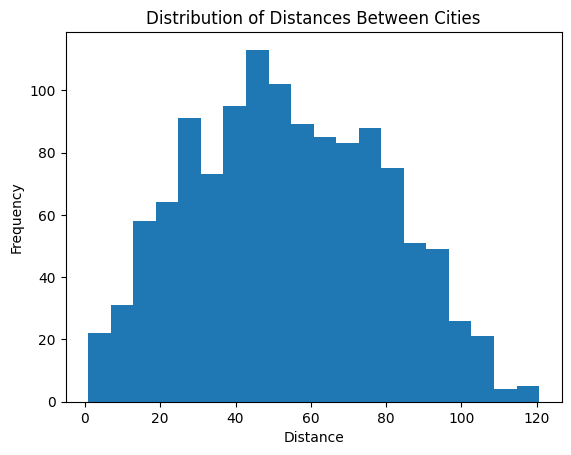

In [101]:
# 3. PAIRWISE DISTANCE HISTOGRAM
distances = []
for i in range(len(cities)):
    for j in range(i + 1, len(cities)):
        distances.append(euclidean_distance(cities[i], cities[j]))

plt.figure()
plt.hist(distances, bins=20)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Distances Between Cities")
plt.show()

In [102]:
# 4. ROUTE PLOTTING FUNCTION
def plot_route(route, title):
    xs = [city[0] for city in route] + [route[0][0]]
    ys = [city[1] for city in route] + [route[0][1]]
    plt.figure()
    plt.plot(xs, ys, marker='o')
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(title)
    plt.show()